Data analysis for PLR-3000 data
===============================

After bluetoothing accross, open the excel spreadsheet and save it in CSV format. Then run the code below.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_context('paper', font_scale=1.5)

#plr3000 = pd.read_csv(
#    r'C:/Users/engs2242/Desktop/PLR-3000/R_20210312_132224.csv')

plr3000 = pd.read_csv(
    r'/Users/jtm/Projects/PyPlr/examples/PFR/data/neuroptics/R_20210414_162809.csv')

Seperate raw data from summary information
------------------------------------------

In [2]:
info = []
raw_data = []
for idx, row in plr3000.iterrows():
    information = row[[col for col in plr3000.columns if not 'Unnamed' in col]]
    raw = row[[col for col in plr3000.columns if 'Unnamed' in col]]
    dl = information['Data Length']
    time = raw.iloc[0:dl].to_numpy()
    pupil = raw.iloc[dl:dl*2].to_numpy()
    valid = raw.iloc[dl*2:dl*3].to_numpy()
    df = pd.DataFrame({'onset': time,
                       'diameter': pupil,
                       'valid': valid}, dtype=float)
    df['Record ID'] = information['Record ID']
    df['Patient ID'] = information['Patient ID']
    raw_data.append(df)
    info.append(information.to_frame().T)

info = pd.concat(info).set_index(['Record ID'])
raw_data = pd.concat(raw_data).set_index(['Record ID', 'onset'])
# set invalid samples to nan
raw_data.loc[raw_data.valid==0, 'diameter'] = np.nan
raw_data['diameter_pc'] = ((raw_data['diameter']/info['PLR Diameter Init'])-1) *100
neuroptics = raw_data.reset_index().rename(columns={'Record ID':'rec','Patient ID':'Subject','diameter':'pupil'})
neuroptics.onset = neuroptics.onset-1
neuroptics['Device'] = 'PLR-3000'
neuroptics.loc[neuroptics.Subject==0, 'Subject'] += 1
neuroptics['Subject'] = 'sub00' + neuroptics['Subject'].astype('str')
neuroptics

,rec,onset,pupil,valid,Subject,diameter_pc,Device
0,179,-1.000,5.659,1.0,sub002,-2.431034,PLR-3000
1,179,-0.967,5.677,1.0,sub002,-2.12069,PLR-3000
2,179,-0.933,5.674,1.0,sub002,-2.172414,PLR-3000
3,179,-0.900,5.654,1.0,sub002,-2.517241,PLR-3000
4,179,-0.866,5.719,1.0,sub002,-1.396552,PLR-3000
...,...,...,...,...,...,...,...
10795,120,7.857,4.500,1.0,sub001,0.0,PLR-3000
10796,120,7.890,4.456,1.0,sub001,-0.977778,PLR-3000
10797,120,7.924,4.497,1.0,sub001,-0.066667,PLR-3000
10798,120,7.957,4.482,1.0,sub001,-0.4,PLR-3000


In [3]:
import os
import os.path as op
import pandas as pd

datapath = r'/Users/jtm/Projects/PyPlr/examples/PFR/data/pyplr'
subs = os.listdir(datapath)
cols = ['diameter','diameter_3d','timestamp','confidence']
trials=[]
for sub in subs:
    subpath = op.join(datapath, sub)
    for rec in os.listdir(subpath):
        recpath = op.join(subpath, rec)
        data = pd.read_csv(op.join(recpath, 'raw_data.csv'), index_col='timestamp', usecols=cols)
        data['onset'] =  range(len(data))
        data['onset'] =  data['onset'] * 1/120-1
        data['Subject'] = sub
        data['rec'] = rec
        trials.append(data.reset_index())
        
trials = pd.concat(trials).reset_index(drop=True).rename(columns={'index':'onset'})
trials = trials.sort_values(['Subject','rec'])
trials

,timestamp,diameter,confidence,diameter_3d,onset,Subject,rec
59400,1541.458415,45.774245,0.983601,5.515972,-1.000000,sub001,rec000
59401,1541.466367,43.318788,0.057888,5.533923,-0.991667,sub001,rec000
59402,1541.474436,39.485776,0.711115,5.549734,-0.983333,sub001,rec000
59403,1541.482452,42.277045,0.739466,5.564221,-0.975000,sub001,rec000
59404,1541.490535,44.399923,0.927758,5.577575,-0.966667,sub001,rec000
...,...,...,...,...,...,...,...
9715,-619413.772202,41.934352,1.000000,4.620638,7.958333,sub002,rec021
9716,-619413.763777,41.980227,1.000000,4.623078,7.966667,sub002,rec021
9717,-619413.756214,41.943199,1.000000,4.625743,7.975000,sub002,rec021
9718,-619413.748166,41.929429,1.000000,4.628636,7.983333,sub002,rec021


In [4]:
rec = ['rec' + str(i).zfill(3) for i in range(21)]

trials.rename(columns={'diameter_3d':'Pupil Core'}, inplace=True)
trials = trials.melt(
    value_vars=['Pupil Core'],
    id_vars=['Subject','rec','onset'],
    value_name='pupil',
    var_name='Device')
trials = trials[trials.Subject!='sub001_old']
trials = trials[trials.rec.isin(rec)]

In [5]:
data = neuroptics.append(trials[['rec', 'onset', 'pupil', 'Subject', 'Device']])
#data = data[data.Method!='Pupil Labs (px)']
data = data.replace({'sub001':'1','sub002':'2'})
data

,rec,onset,pupil,valid,Subject,diameter_pc,Device
0,179,-1.000000,5.659000,1.0,2,-2.431034,PLR-3000
1,179,-0.967000,5.677000,1.0,2,-2.120690,PLR-3000
2,179,-0.933000,5.674000,1.0,2,-2.172414,PLR-3000
3,179,-0.900000,5.654000,1.0,2,-2.517241,PLR-3000
4,179,-0.866000,5.719000,1.0,2,-1.396552,PLR-3000
...,...,...,...,...,...,...,...
69115,rec020,7.958333,4.634288,NaN,2,NaN,Pupil Core
69116,rec020,7.966667,4.637116,NaN,2,NaN,Pupil Core
69117,rec020,7.975000,4.639803,NaN,2,NaN,Pupil Core
69118,rec020,7.983333,4.642363,NaN,2,NaN,Pupil Core


In [6]:
data

,rec,onset,pupil,valid,Subject,diameter_pc,Device
0,179,-1.000000,5.659000,1.0,2,-2.431034,PLR-3000
1,179,-0.967000,5.677000,1.0,2,-2.120690,PLR-3000
2,179,-0.933000,5.674000,1.0,2,-2.172414,PLR-3000
3,179,-0.900000,5.654000,1.0,2,-2.517241,PLR-3000
4,179,-0.866000,5.719000,1.0,2,-1.396552,PLR-3000
...,...,...,...,...,...,...,...
69115,rec020,7.958333,4.634288,NaN,2,NaN,Pupil Core
69116,rec020,7.966667,4.637116,NaN,2,NaN,Pupil Core
69117,rec020,7.975000,4.639803,NaN,2,NaN,Pupil Core
69118,rec020,7.983333,4.642363,NaN,2,NaN,Pupil Core


In [7]:
data = data.sort_values('Subject')

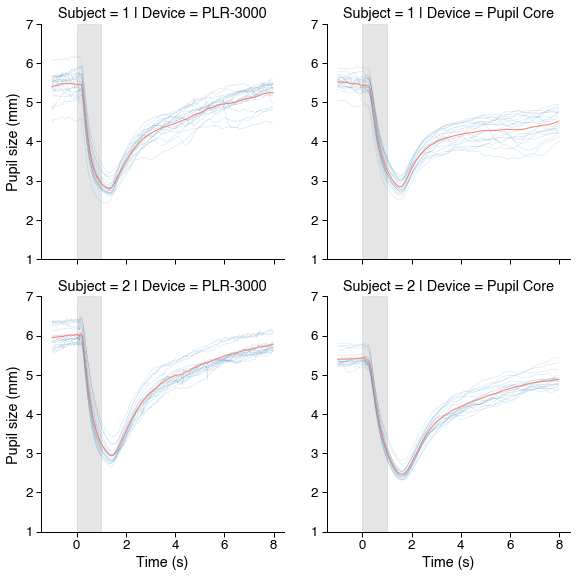

In [8]:
order = ['PLR-3000', 'Pupil Core']
g = sns.FacetGrid(data=data, row='Subject', col='Device', sharey=False, row_order=['1','2'], margin_titles=False, height=4, col_order=order)
g.map_dataframe(sns.lineplot, x='onset', y='pupil', estimator=None, units='rec', lw=.1)
g.map_dataframe(sns.lineplot, x='onset', y='pupil', ci=None, lw=1, color='salmon')

axs = [ax for sublist in g.axes for ax in sublist]
for i, ax in enumerate(axs):
    ax.axvspan(0,1,color='k', alpha=.1)
    ax.set_xlabel('Time (s)')
    ax.set_ylim((1,7))
    if i%2 == 0:
        ax.set_ylabel('Pupil size (mm)')

g.savefig('../img/PLR-3000-Pupil-Core-PLRs.tiff', dpi=300)

In [9]:
cols = ['PLR Diameter Init', 'PLR Diameter End', 'PLR Latency',
       'PLR Constriction Velocity', 'PLR Max Constriction Velocity',
       'PLR Dilation Velocity', 'PLR T75']
info[cols] = info[cols].astype('float')
info.groupby('Patient ID')[cols].agg('mean')


,PLR Diameter Init,PLR Diameter End,PLR Latency,PLR Constriction Velocity,PLR Max Constriction Velocity,PLR Dilation Velocity,PLR T75
Patient ID,,,,,,,
0,5.44,2.785,0.2165,-3.5425,-6.121,1.0380,3.809444
2,6.02,2.935,0.2285,-3.4690,-5.769,1.1395,3.556500


In [10]:
info.groupby('Patient ID')[cols].agg('std')

,PLR Diameter Init,PLR Diameter End,PLR Latency,PLR Constriction Velocity,PLR Max Constriction Velocity,PLR Dilation Velocity,PLR T75
Patient ID,,,,,,,
0,0.357477,0.178517,0.015313,0.305405,0.478230,0.199832,1.217154
2,0.206729,0.184320,0.006708,0.222590,0.393231,0.170309,0.548800


In [11]:
info

,Device ID,Patient ID,Time,MeasurementType,Pupil Measured,ABN,Static Measurement Duration,Static Led in uW,Static Mean,Static Std,...,PLR Pulse Led in uW,PLR Bkg Led in uW,PLR Diameter Init,PLR Diameter End,PLR Latency,PLR Constriction Velocity,PLR Max Constriction Velocity,PLR Dilation Velocity,PLR T75,Data Length
Record ID,,,,,,,,,,,,,,,,,,,,,
179,3PK200021,2,14/04/2021 15:03,1,Right,0,NaN,NaN,NaN,NaN,...,180,0,5.8,2.8,0.23,-3.46,-6.09,1.38,3.71,270
177,3PK200021,2,14/04/2021 15:02,1,Right,0,NaN,NaN,NaN,NaN,...,180,0,6.0,2.9,0.23,-3.61,-6.07,1.01,4.04,270
175,3PK200021,2,14/04/2021 15:01,1,Right,0,NaN,NaN,NaN,NaN,...,180,0,5.8,2.8,0.23,-3.73,-6.03,1.25,3.34,270
174,3PK200021,2,14/04/2021 15:00,1,Right,0,NaN,NaN,NaN,NaN,...,180,0,5.8,2.7,0.23,-3.90,-6.11,1.32,3.11,270
173,3PK200021,2,14/04/2021 15:00,1,Right,0,NaN,NaN,NaN,NaN,...,180,0,5.9,2.8,0.23,-3.87,-6.36,0.88,3.88,270
172,3PK200021,2,14/04/2021 14:51,1,Right,0,NaN,NaN,NaN,NaN,...,180,0,6.2,3.1,0.23,-3.41,-5.51,1.17,3.01,270
171,3PK200021,2,14/04/2021 14:51,1,Right,0,NaN,NaN,NaN,NaN,...,180,0,6.0,2.9,0.23,-3.41,-5.96,1.06,3.41,270
170,3PK200021,2,14/04/2021 14:50,1,Right,0,NaN,NaN,NaN,NaN,...,180,0,5.9,2.8,0.23,-3.66,-6.07,1.33,3.44,270
168,3PK200021,2,14/04/2021 14:48,1,Right,0,NaN,NaN,NaN,NaN,...,180,0,6.0,2.8,0.23,-3.59,-5.96,0.79,3.84,270


In [12]:
from pyplr.plr import PLR

params = []
plrs = []

for idxs, df in trials.groupby(['Subject', 'rec']):
    data = df.loc[df.Device=='Pupil Core', 'pupil'].to_numpy()
    plrs.append(data)
    plr = PLR(data, sample_rate=120, onset_idx=120, stim_duration=1)
    parameters = plr.parameters().T
    parameters[['Subject', 'Rec']] = idxs
    params.append(parameters)
params = pd.concat(params).set_index(['Subject', 'Rec'])
params['T2Rec75pc'] = params['T2Rec75pc'].replace(0., np.nan)
params

Baseline  Latency_a  Latency_b  T2MaxVel  T2MaxCon  T2Rec75pc  \
Subject Rec                                                                     
sub001  rec000  5.573743   0.341667   0.291667  0.500000  1.541667        NaN   
        rec001  5.552783   0.300000   0.333333  0.425000  1.558333        NaN   
        rec002  5.587755   0.416667   0.075000  0.458333  1.566667        NaN   
        rec003  5.616102   0.308333   0.383333  0.475000  1.550000        NaN   
        rec004  5.623108   0.300000   0.316667  0.458333  1.533333        NaN   
        rec005  5.433018   0.316667   0.308333  0.433333  1.541667   5.691667   
        rec006  5.329592   0.316667   0.300000  0.433333  1.500000   5.216667   
        rec007  5.477847   0.083333   0.283333  0.500000  1.550000        NaN   
        rec008  5.379533   0.275000   0.300000  0.416667  1.558333        NaN   
        rec009  5.429457   0.150000   0.341667  0.441667  1.525000        NaN   
        rec010  5.486191   0.175000   0.333333  0.441667  1.533333   6.200000   
        rec011  5.427741   0.150000   0.333333  0.441667  1.533333        NaN   
        rec012  5.371180   0.116667   0.308333  0.433333  1.533333        NaN   
        rec013  5.875275   0.250000   0.308333  0.425000  1.583333        NaN   
        rec014  5.537837   0.291667   0.275000  0.441667  1.525000        NaN   
        rec015  5.283486   0.266667   0.308333  0.416667  1.500000        NaN   
        rec016  5.331673   0.083333   0.308333  0.425000  1.516667        NaN   
        rec017  4.964775   0.233333   0.300000  0.408333  1.508333        NaN   
        rec018  5.511545   0.291667   0.291667  0.408333  1.491667   6.125000   
        rec019  5.771392   0.108333   0.316667  0.425000  1.566667        NaN   
        rec020  5.664677   0.091667   0.308333  0.433333  1.550000        NaN   
sub002  rec000  5.503581   0.100000   0.308333  0.433333  1.575000   4.050000   
        rec001  5.279940   0.125000   0.308333  0.441667  1.625000   3.141667   
        rec002  5.251586   0.233333   0.316667  0.433333  1.666667   3.641667   
        rec003  5.208288   0.191667   0.308333  0.425000  1.608333   4.433333   
        rec004  5.331752   0.275000   0.308333  0.425000  1.641667   3.866667   
        rec005  5.410152   0.283333   0.308333  0.425000  1.616667   4.233333   
        rec006  5.383958   0.283333   0.300000  0.408333  1.625000   4.058333   
        rec007  5.756188   0.275000   0.300000  0.416667  1.608333   4.158333   
        rec008  5.679946   0.258333   0.308333  0.416667  1.600000   4.141667   
        rec009  5.778732   0.258333   0.308333  0.425000  1.658333   3.850000   
        rec010  5.440226   0.150000   0.316667  0.425000  1.608333   5.575000   
        rec011  5.697870   0.241667   0.300000  0.416667  1.650000        NaN   
        rec012  5.365434   0.291667   0.300000  0.416667  1.575000   5.100000   
        rec013  5.357315   0.133333   0.308333  0.441667  1.608333   4.600000   
        rec014  5.169137   0.241667   0.333333  0.433333  1.633333   4.075000   
        rec015  5.286627   0.150000   0.316667  0.425000  1.550000   5.033333   
        rec016  5.353409   0.225000   0.308333  0.425000  1.558333   4.550000   
        rec017  5.328432   0.158333   0.300000  0.441667  1.550000   5.158333   
        rec018  5.285107   0.158333   0.316667  0.450000  1.608333   5.000000   
        rec019  5.338398   0.166667   0.316667  0.433333  1.575000   4.491667   
        rec020  5.351023   0.225000   0.308333  0.425000  1.625000   5.050000   

                 PeakCon  ConAmplitude  VelConMax  VelConAve   AccConMax  \
Subject Rec                                                                
sub001  rec000  3.099868      2.473876   4.060254   2.004233   61.760663   
        rec001  3.137805      2.414978   4.263885   1.927802   33.331619   
        rec002  3.021226      2.566529   4.865049   1.893880  187.839407   
        rec003  2.996566      2.619536   4.292455   2.036843   43.35024

In [13]:
params.groupby(level=[0]).agg('mean')

,Baseline,Latency_a,Latency_b,T2MaxVel,T2MaxCon,T2Rec75pc,PeakCon,ConAmplitude,VelConMax,VelConAve,AccConMax,ConTime,VelRedAve,VelRedMax,AccRedMax
Subject,,,,,,,,,,,,,,,
sub001,5.487081,0.231746,0.301190,0.440079,1.536508,5.808333,2.847437,2.639645,4.649154,1.958865,45.904388,1.304762,0.352802,1.501811,9.272317
sub002,5.407481,0.210714,0.309524,0.427778,1.607937,4.410417,2.457270,2.950211,4.550452,2.105594,36.164056,1.397222,0.409973,1.398711,7.448599


In [14]:
params.groupby(level=[0]).agg('std')

,Baseline,Latency_a,Latency_b,T2MaxVel,T2MaxCon,T2Rec75pc,PeakCon,ConAmplitude,VelConMax,VelConAve,AccConMax,ConTime,VelRedAve,VelRedMax,AccRedMax
Subject,,,,,,,,,,,,,,,
sub001,0.189923,0.098799,0.056843,0.025769,0.024221,0.453638,0.176120,0.154410,0.326510,0.142838,33.401989,0.101741,0.038973,0.163715,1.302046
sub002,0.176443,0.060619,0.008030,0.010319,0.033899,0.604472,0.133856,0.148695,0.342153,0.152846,10.100089,0.056355,0.034808,0.105391,1.149259


In [15]:
df = pd.DataFrame(plrs)
df.columns = df.columns.astype('float') / 120
df.to_csv('example_plrs.csv', index=False)

In [16]:
df

,0.000000,0.008333,0.016667,0.025000,0.033333,0.041667,0.050000,0.058333,0.066667,0.075000,...,8.916667,8.925000,8.933333,8.941667,8.950000,8.958333,8.966667,8.975000,8.983333,8.991667
0,5.515972,5.533923,5.549734,5.564221,5.577575,5.589566,5.599875,5.608285,5.614772,5.619576,...,4.568432,4.570701,4.573191,4.575866,4.578680,4.581585,4.584546,4.587548,4.590601,4.593713
1,5.455322,5.455876,5.457365,5.459446,5.461743,5.463921,5.465747,5.467146,5.468207,5.469106,...,4.213504,4.214264,4.215119,4.216078,4.217157,4.218372,4.219740,4.221273,4.222990,4.224901
2,5.640951,5.637915,5.635320,5.632986,5.630833,5.628870,5.627117,5.625575,5.624246,5.623149,...,4.451080,4.453790,4.456245,4.458498,4.460602,4.462608,4.464558,4.466481,4.468402,4.470344
3,5.640674,5.653869,5.663592,5.670106,5.673790,5.675107,5.674549,5.672563,5.669541,5.665842,...,4.438434,4.442640,4.446893,4.451188,4.455516,4.459854,4.464170,4.468447,4.472687,4.476925
4,5.579885,5.585881,5.591779,5.597419,5.602626,5.607239,5.611157,5.614364,5.616925,5.618961,...,4.732925,4.736851,4.740795,4.744682,4.748448,4.752048,4.755465,4.758708,4.761810,4.764826
5,5.589009,5.584609,5.578833,5.571996,5.564491,5.556751,5.549144,5.541902,5.535183,5.529167,...,4.949546,4.949838,4.950131,4.950411,4.950663,4.950886,4.951101,4.951336,4.951619,4.951970
6,5.433068,5.429049,5.424714,5.420067,5.415139,5.409962,5.404567,5.398977,5.393221,5.387359,...,4.747905,4.748805,4.749609,4.750347,4.751063,4.751813,4.752659,4.753674,4.754932,4.756496
7,5.472618,5.472613,5.472443,5.472172,5.471822,5.471386,5.470863,5.470305,5.469856,5.469661,...,4.635967,4.638369,4.640524,4.642482,4.644274,4.645923,4.647442,4.648829,4.650071,4.651145
8,5.386472,5.386730,5.386975,5.387238,5.387537,5.387875,5.388247,5.388644,5.389051,5.389459,...,4.277158,4.276163,4.275110,4.274021,4.272907,4.271772,4.270626,4.269477,4.268333,4.267190
9,5.389712,5.396232,5.402202,5.407820,5.413149,5.418149,5.422770,5.426998,5.430846,5.434319,...,4.713720,4.717511,4.720972,4.724075,4.726805,4.729163,4.731170,4.732854,4.734246,4.735373
